In [1]:
import datetime as dt
import os

import numpy as np

from coropy import simulate

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

# 1st wave data
start_date_1 = dt.datetime(2020, 2, 26)
end_date_1 = dt.datetime(2020, 6, 5)
diff = abs((end_date_1 - start_date_1).days)

confirmed_cases_1 = confirmed_cases[:diff+1]
recovered_cases_1 = recovered_cases[:diff+1]
death_cases_1 = death_cases[:diff+1]
removed_cases_1 = removed_cases[:diff+1]
active_cases_1 = active_cases[:diff+1]

# 2nd wave data
start_date_2 = dt.datetime(2020, 6, 6)
confirmed_cases_2 = confirmed_cases[diff+1:]
recovered_cases_2 = recovered_cases[diff+1:]
death_cases_2 = death_cases[diff+1:]
removed_cases_2 = removed_cases[diff+1:] - removed_cases[diff+1]
active_cases_2 = active_cases[diff+1:]

In [3]:
S0 = 2200
E0 = 3 * active_cases_1[0]
I0 = active_cases_1[0]
R0 = removed_cases_1[0]

(S, E, I, R), _, loss = simulate.seir_dynamics(
    active_cases=active_cases_1, 
    removed_cases=recovered_cases_1, 
    initial_conditions=(S0, E0, I0, R0),
    epidemics_start_date=start_date_1,
    plot_sim=True,
    plot_l=True,
)

TypeError: fit() missing 1 required positional argument: 'IC'

In [3]:
from coropy.compartmental_models import SEIRModel
S0 = 2200
E0 = 3 * active_cases_1[0]
I0 = active_cases_1[0]
R0 = removed_cases_1[0]

In [4]:
model = SEIRModel(calc_ci=True, pcr_sens=0.9, pcr_spec=0.99, daily_tests=daily_tests[:diff+1])

In [5]:
_, _ = model.fit(confirmed_cases_1, recovered_cases_1, death_cases_1, 
          IC=(2200, 10, 1, 0))

INFO:root:L-BFGS-B optimization started: 2020-10-02 15:59:19.785778
INFO:root:Elapsed time: 29.6455s


In [6]:
(S, E, I, R) = model.simulate()

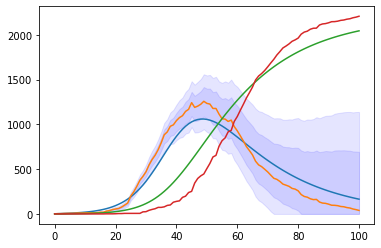

In [7]:
import matplotlib.pyplot as plt
plt.fill_between(list(range(len(I[0]))), I[0], I[4], color='b', alpha=0.1)
plt.fill_between(list(range(len(I[0]))), I[1], I[3], color='b', alpha=0.1)
plt.plot(I[2])
plt.plot(active_cases_1)
plt.plot(R)
plt.plot(removed_cases_1)

In [8]:
model.get_params

array([3.63615367e-01, 1.00000000e-05, 1.77131359e-01, 4.45045039e-02])

In [25]:
if b is None:
    print(1)

NameError: name 'b' is not defined